# Segmentation testing and generation of a reference image

Use this notebook to:

1. separately test each step used in the detection and segmentation of the surface of the object in one image stack, and visualize the result after each step. 

2. explore the effect of the segmentation parameters and find the best values for the current dataset.

3. align the segmented image and the corresponding mask and save them as references to register multiple 3D stacks.

In [1]:
# import packages 
from skimage import io, transform
import numpy as np
import open3d as o3d
import napari
import os
from skimage import morphology
from scipy import stats, ndimage
import matplotlib.pyplot as plt
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

from src.preprocess import segmentation_with_optimized_thresh, image_padding, refine_surface_mask, refine_surface_mask_with_mesh_interpolation
from src.aux_pcd_functions import pcd_to_image, image_to_pcd
from src.registration import pick_points


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Set parameters:

In [2]:
# Downscaling of confocal stacks along z,x,y, 
# pick numbers that make the resolution isotropic:
downscaling = (1, 2.5, 2.5) 

# Bit depth of raw images 
# (depending on the detector settings this may be 8, 12 or 16)
bit_depth = 12

# Default values of the parameters used for the segmentation:
segm_pars={'threshold': 1.05, 'max_iter': 200,'fraction_range': [0.04, 0.05], 
           'padding': 20, 'closing_r': 4, 'dilation_r': 2, 'mesh_radius': 10}

### Downscaling and visualization of raw data

In [3]:
# Load the image, only fluorescence channel is required:
reference_fly_filename = "../test_dataset/01_raw/C1-Image1.tif"
#reference_fly_filename = "../test_dataset/References_and_masks/C1_Reference_iso.tiff"

image = io.imread(reference_fly_filename)

# Apply downscaling and visualize the stack:
new_image_shape = [int(image.shape[i]/downscaling[i]) for i in range(3)]
image_downscaled = transform.resize(image, new_image_shape, preserve_range = True, anti_aliasing=True)
viewer = napari.view_image(image_downscaled)

### Thresholding:

In [4]:
# Segment:
Thresholded_Image = segmentation_with_optimized_thresh(image_downscaled,
                                                       segm_pars['threshold'], 
                                                       segm_pars['max_iter'], 
                                                       segm_pars['fraction_range'])
viewer = napari.view_image(Thresholded_Image)

## Clean up the segmented volume with morphological transformations:

In [5]:
# Padding:
Mask_padded  = image_padding(Thresholded_Image, padding = segm_pars['padding'])
Image_padded = image_padding(image_downscaled, padding = segm_pars['padding'])

# Clean up the segmentation with morphological transformations:
Refined_Mask = refine_surface_mask(Mask_padded, Image_padded, segm_pars['closing_r'], segm_pars['mesh_radius'])

# Visualize the result:
viewer = napari.view_image(Refined_Mask)

## Transform the segmented volume in a point cloud object and fit a mesh to fill potential holes:

In [6]:
# Define functions to visualize the point cloud object:

def custom_draw(pcd):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    
def custom_draw_w_mesh(pcd, mesh):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(pcd)
    vis.add_geometry(mesh)
    vis.run()
    vis.destroy_window()
    
def draw_pcd(pcd):
    pcd_temp = copy.deepcopy(pcd)
    pcd_temp.paint_uniform_color([1, 0.706, 0])
    o3d.visualization.draw_geometries([pcd_temp])


# Transform the mask surface in a point cloud and interpolate it with a mesh:
mesh_pcd, mesh_pcd_values, original_pcd, mesh = refine_surface_mask_with_mesh_interpolation(
                                        Refined_Mask, segm_pars['mesh_radius'])

custom_draw_w_mesh(original_pcd, mesh)
custom_draw(mesh_pcd)

## Create a mask from the mesh and apply it to the original image stack:

In [7]:
mask_thin = pcd_to_image(mesh_pcd, mesh_pcd_values, Refined_Mask.shape)
viewer = napari.view_image(Image_padded*mask_thin)

## Select the meridian plane of the segmented object

In this step, select a series of points along a line on the segmented surface that will define the meridian plane for the 2D projection of the images.

In [8]:
"""
1)  Please pick at least three points along the meridian plane of your image using [shift + left click]
    Press [shift + right click] to undo point picking)
2)  After picking points, press 'Q' to close the window

"""

# Tune the brightness of surface:
brightness_max = 2

# Tune the point size of surface viewer:
pt_size = 12

pcd, pcd_values = image_to_pcd(mask_thin*Image_padded)
bw_colors = brightness_max*(pcd_values-np.min(pcd_values))/np.max(pcd_values)

'Pick points along the equatorial plane'
pcd.colors = o3d.utility.Vector3dVector(np.asarray([bw_colors, bw_colors, bw_colors]).T)
points_equatorial_plane = pick_points(pcd, pt_size, window_name = "Pick points along equatorial plane")

'Pick points along the meridian plane'
pcd.colors = o3d.utility.Vector3dVector(np.asarray([bw_colors, bw_colors, bw_colors]).T)
points_meridian_plane = pick_points(pcd, pt_size, window_name = "Pick points along meridian plane")

### Fit the equatorial plane and the meridian plane through the selected points:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
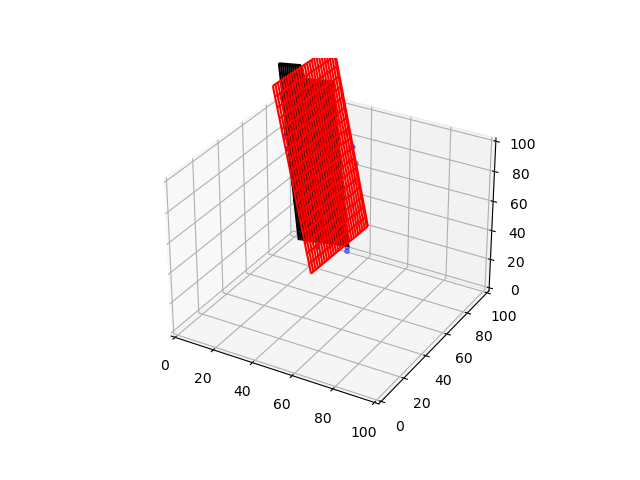

In [9]:
%matplotlib widget
from scipy.linalg import lstsq

# Linear fit of equatorial plane in the form f0*x+f1*y+f2 = z
tmp_A = []
tmp_b = []
pts_x = []
pts_y = []
pts_z = []

for point_idx in points_equatorial_plane:
    [x, y, z] = pcd.points[point_idx]
    tmp_A.append([x, y, 1])
    tmp_b.append(z)    
    pts_x.append(x)
    pts_y.append(y)
    pts_z.append(z)

b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# fit the equatorial plane 
fit_e, residual, rnk, s = lstsq(A, b)

e_plane_a = fit_e[0,0]
e_plane_b = fit_e[1,0]
e_plane_c = fit_e[2,0]

# define the meridian plane orthogonal to the equatorial plane
# and prepare data for fitting:

tmp_A = []
tmp_b = []
for point_idx in points_meridian_plane:
    [x, y, z] = pcd.points[point_idx]
    tmp_A.append([(e_plane_a*y-e_plane_b*x), e_plane_a])
    tmp_b.append(e_plane_a*z+x)
    pts_x.append(x)
    pts_y.append(y)
    pts_z.append(z)

b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

fit_m, residual, rnk, s = lstsq(A, b)

m_plane_a = -(1+e_plane_b*fit_m[0,0])/e_plane_a
m_plane_b = fit_m[0,0]
m_plane_c = fit_m[1,0]


# plot the result of the fit:
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(pts_x, pts_y, pts_z, color='b', s = 10)

ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_zlim([0,100])

X,Y = np.meshgrid(np.arange(min(pts_x), max(pts_x)),
                  np.arange(min(pts_y), max(pts_y)))
Z = np.zeros(X.shape)

for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        temp_z = m_plane_a * X[r,c] + m_plane_b * Y[r,c] + m_plane_c
        if (temp_z > 0.75*min(pts_z)) & (temp_z < 1.5*max(pts_z)):
            Z[r,c] = temp_z
        else:
            Z[r,c] = np.nan

ax.plot_wireframe(X,Y,Z, color='k')

for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        temp_z = e_plane_a * X[r,c] + e_plane_b * Y[r,c] + e_plane_c
        if (temp_z > 0.75*min(pts_z)) & (temp_z < 1.5*max(pts_z)):
            Z[r,c] = temp_z
        else:
            Z[r,c] = np.nan
            
ax.plot_wireframe(X,Y,Z, color='r')

### Apply an affine transformation to align the axis with the meridian and equatorial planes and center the image around the center of the segmented surface.

In [21]:
## Change of coordinates:
new_z = np.array([[e_plane_a, e_plane_b, -1]])
new_z = -new_z/np.sum(new_z)
new_y = np.array([[m_plane_a, m_plane_b, -1]])
new_y = -new_y/np.sum(new_y)
new_x = np.array(np.cross(new_z, new_y))

Inv_transf_M = np.hstack((new_z.T, new_y.T, new_x.T))
Dir_trans_M = np.linalg.inv(Inv_transf_M)

pcd_center = pcd.get_center().T
offset = pcd_center-np.matmul(Inv_transf_M,pcd_center)

center = np.array(Image_padded.shape)/2
Rotated_image = ndimage.affine_transform(Image_padded, Inv_transf_M, offset=offset, order=0)

Rotated_thin_mask = ndimage.affine_transform(mask_thin, Inv_transf_M, offset=offset, order=1)>0.1
Final_mask = morphology.dilation(Rotated_thin_mask, morphology.ball(segm_pars['dilation_r']))

viewer = napari.view_image(Rotated_image*Final_mask)

## Save the reference image

In [22]:
# Save it as reference
from tifffile import imsave

# save the segmented part of the image:
imsave("../test_dataset/References_and_masks/C1_Reference_iso.tiff", (Rotated_image*Final_mask).astype(np.uint16))
# save the mask:
imsave("../test_dataset/References_and_masks/Reference_mask_iso.tiff", (Final_mask).astype(np.uint16))
# save a dilated version of the mask:
Dilated_mask = morphology.dilation(Final_mask, morphology.ball(2))
imsave("../test_dataset/References_and_masks/Reference_mask_iso_thick.tiff", (Dilated_mask).astype(np.uint16))